For this chapter we'll be participating in a real kaggle competition and evaluate each of the regularization techniques of the chapter 7                                                                                                               
https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/overview                                                       
dataset from                                                                                                                  
https://www.kaggle.com/c/rsna-str-pulmonary-embolism-detection/discussion/182930

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# import cv2
import glob

from tqdm import tqdm

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device
    
device

device(type='cuda')

In [3]:
train_path = 'D:\\lungs\\train-jpegs'
csv_path = 'E:\\Download\\new_downloads\\train.csv'

In [4]:
df_train = pd.read_csv(csv_path)

In [5]:
df_train.shape

(1790594, 17)

In [6]:
df_train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [7]:
df_train.tail()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
1790589,4833c9b6a5d0,57e3e3c5f910,da0ecef50cf5,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790590,4833c9b6a5d0,57e3e3c5f910,d74b46c2f2c4,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790591,4833c9b6a5d0,57e3e3c5f910,ba71189191ad,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790592,4833c9b6a5d0,57e3e3c5f910,f4fdc88f2ace,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790593,4833c9b6a5d0,57e3e3c5f910,f890efd48940,1,0,0,0,0,0,1,1,1,0,0,0,0,0


In [8]:
image_level_features = ['pe_present_on_image']
# exam_level_features = ['negative_exam_for_pe', 
exam_level_features = ['indeterminate', 'chronic_pe', 'acute_and_chronic_pe', 'central_pe', 'leftsided_pe', 'rightsided_pe', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',]
informational_features = ['qa_motion', 'qa_contrast', 'true_filling_defect_not_pe', 'flow_artifact']

In [9]:
df_train.loc[df_train['pe_present_on_image'] == 0, exam_level_features] = 0
df_train[df_train.pe_present_on_image == 1].shape[0], df_train[df_train.pe_present_on_image == 0].shape[0], df_train[df_train.pe_present_on_image == 1].shape[0]/df_train[df_train.pe_present_on_image == 0].shape[0] # high inbalance

train_df_0 = df_train[df_train.pe_present_on_image == 0].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*1.5), replace=False)
train_df_1 = df_train[df_train.pe_present_on_image == 1].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*0.8), replace=False)

In [10]:
train_df = train_df_0.append(train_df_1, ignore_index=False)

In [11]:
train_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
1696033,1b6fe7163ff7,e56b902715e4,5f23e9bcaa09,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1505951,ba776f6ba060,226d55534669,6924d9c2e9dc,0,1,0,0,0,0,0,0,0,0,0,0,0,0
526003,7aeac3420cf8,417a4c7bb0e2,3749e07786f7,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1243285,45d5bce5d7dd,045d61b8a2d7,6a635ecab6af,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1053956,0207ff3d6b14,bc2f6deda504,1ab0e8fdf9d5,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526653,34609159bf1e,a8cf1798891d,ced7604d3406,1,0,0,0,0,1,0,0,0,0,1,0,0,0
319074,bfbb72f37ace,e24e3deffd9b,ad78c5200a6f,1,0,0,0,0,0,1,1,0,0,0,0,0,0
138750,ee795818d9e7,59a5a9174056,8a56ce271a28,1,0,0,0,0,0,1,0,0,0,1,0,1,0
1781816,093e2300daa5,e1fa3ea2df2a,1f0c2ea56b63,1,0,0,0,0,1,0,1,0,0,1,0,1,0


In [12]:
df_train = df_train.drop(train_df.index)

In [13]:
# df_train[df_train.pe_present_on_image==1]
val_df = df_train[df_train.pe_present_on_image==1].append(df_train[df_train.pe_present_on_image==0].sample(int(df_train[df_train.pe_present_on_image == 1].shape[0]*1.5), replace=False))

In [14]:
val_df = val_df.sample(frac=1).reset_index(drop=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [15]:
del df_train

In [16]:
train_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,589d45cdeb78,5a5f7e1b3f4c,08d4e5a5ba89,1,0,0,0,0,0,1,1,0,0,1,1,1,0
1,a65cc22aac5e,44074501531f,3f6c954cf776,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,ce7b3c57aced,12b5b351c726,fd2631fb6d5a,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,44690b1a18e7,4f216bb539ee,36ea50d57a9f,1,0,0,0,0,0,1,1,0,0,1,0,0,0
4,027ea0ce3e00,e83841f6e0a7,00358e571cb7,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222037,2151dd8b5893,7758665471c0,2b77b9115593,1,0,0,0,0,1,0,1,0,0,1,0,1,0
222038,eb51866151eb,90888f3875d4,9a12af7d9beb,1,0,0,0,0,1,0,1,0,0,1,0,1,0
222039,2a2a5384f454,db71eb42ef45,01327ad892f8,1,0,0,0,0,1,0,1,0,0,1,0,0,0
222040,ffe7efaccbb9,876a714ad99f,47d7e9586226,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
val_df

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,40c3e2728960,45675b7e4ece,ec90473bcab0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,f29726065b6e,acaf623dee15,3f6a53e183de,1,0,0,0,0,0,1,1,0,0,1,0,0,0
2,73612ef643d8,852a59c86298,c0d73b820e8a,1,0,0,0,0,0,1,1,0,0,0,0,0,0
3,e4a5e780409e,26309713cb31,a345e7559139,1,0,0,0,0,0,1,1,0,0,0,0,1,0
4,931b8d3eec31,e447285c0786,c0c289274428,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48265,a65ef4139811,82cdd360b55b,d217e351d639,0,1,0,0,1,0,0,0,0,0,0,0,0,0
48266,c3907f554dbc,40843c82875b,c2fb9b0d7709,0,1,0,0,0,0,0,0,0,0,0,0,0,0
48267,86a27756b5a9,f63971ca5878,423b9b1310a4,0,1,0,0,0,0,0,0,0,0,0,0,0,0
48268,5068fbd759e2,41fbdcc5b9c0,6411cbf93dbb,1,0,0,0,0,0,1,1,0,0,1,0,0,0


In [18]:
def get_an_image(df, idx=0):
    row = df.iloc[idx]
    img = Image.open(glob.glob(f"{train_path}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])
    return img

In [19]:
img = get_an_image(train_df, 0)

In [20]:
np.array(img).shape

(256, 256, 3)

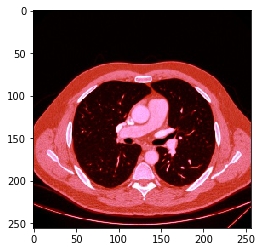

In [21]:
plt.imshow(img)

In [22]:
def plot_image(img):
    plt.figure(figsize=[12,6])
    plt.subplot(131)
    plt.imshow(img[:,:,0],cmap='gray')
    plt.subplot(132)
    plt.imshow(img[:,:,1],cmap='gray')
    plt.subplot(133)
    plt.imshow(img[:,:,2],cmap='gray')

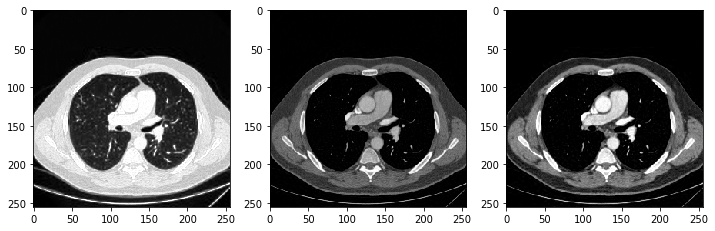

In [23]:
plot_image(np.array(img))

In [24]:
class LungsDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):

        row = self.csv_file.iloc[idx]
        img = Image.open(glob.glob(f"{train_path}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])

        img = self.transform(img).to(device)
        targets = torch.tensor(row[image_level_features+exam_level_features + informational_features].values.astype(np.float16)).float().to(device)

        return img, targets

In [25]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

ds_trans = transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                
#                                 transforms.CenterCrop(224),
                                normalize
])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [26]:
train_dataset = LungsDataset(train_df, transform=ds_trans)

val_dataset = LungsDataset(val_df, transform=ds_trans)

len(train_dataset), len(val_dataset)

(222042, 48270)

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [28]:
# xx = 0
# yy = 0
# for i, x in enumerate(train_dataloader):
# #     print('AAAAAAAAA', x[0].shape, x[1].shape)
# #     print(x[0])
    
#     print('---'*40)
#     if i == 0:
#         xx = x[0]
#     if i == 1:
#         yy = x[1]
#         break
# #     print(x[1])

In [29]:
# len(x)

In [30]:
# xx.shape, yy.shape

In [31]:
# plot_image(xx[0].cpu().permute(1,2,0))

In [32]:
# yy[3].shape

In [33]:
# plot_image(xx[3].cpu().permute(1,2,0))

In [34]:
# df_train.columns

In [35]:
resnet101 = models.resnet50()
fc_feat_size = resnet101.fc.in_features
resnet101.fc.in_features, resnet101.fc.out_features

(2048, 1000)

In [36]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def __forward__(self, x):
        x = x.view(x.size(0), -1)
        return x
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

In [37]:
resnet101.avgpool = Identity()
resnet101.fc = Identity()

In [38]:
resnet101

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
image_level_features+exam_level_features+informational_features

['pe_present_on_image',
 'indeterminate',
 'chronic_pe',
 'acute_and_chronic_pe',
 'central_pe',
 'leftsided_pe',
 'rightsided_pe',
 'rv_lv_ratio_gte_1',
 'rv_lv_ratio_lt_1',
 'qa_motion',
 'qa_contrast',
 'true_filling_defect_not_pe',
 'flow_artifact']

In [40]:
fc_feat_size

2048

In [41]:
# fc_feat_size = 1024
def weights_init(m):
    classname = m.__class__.__name__
    for l in m.modules():
        if isinstance(l, nn.Conv2d):
            torch.nn.init.uniform_(l.weight)
        elif isinstance(l, nn.BatchNorm2d):
            torch.nn.init.uniform_(l.weight)
        elif isinstance(l, nn.Linear):
            torch.nn.init.xavier_normal_(l.weight)
        
class MultiTaskHead(nn.Module):
    def __init__(self):
        super(MultiTaskHead, self).__init__()
        self.m = nn.Sequential(
                nn.Conv2d(2048, 512, kernel_size=(1,1), stride=(1,1), bias=False), 
                nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
                nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                nn.AdaptiveAvgPool2d(output_size=(1,1)),
        )
        self.l = nn.Sequential(
                nn.Linear(fc_feat_size, 1, bias=True), 
#                 nn.ReLU(),
#                 nn.Linear(512, 1), 
                nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.shape[0], 2048, int(np.sqrt(x.shape[1]/2048)), int(np.sqrt(x.shape[1]/2048)))
        x = self.m(x)
        x = self.l(x.squeeze())
        return x

class WrapperModel(nn.Module):
    def __init__(self, pretrained_model):
        super(WrapperModel, self).__init__()
        self.stage = 'train'
        
        self.backbone = pretrained_model
        '''
        image-level feature
        '''
        self.linear_pe_present_on_image = MultiTaskHead()
        weights_init(self.linear_pe_present_on_image)
        '''
        exam-level features
        '''
        self.linear_negative_exam_for_pe = MultiTaskHead()
        weights_init(self.linear_negative_exam_for_pe)
        
        self.linear_indeterminate = MultiTaskHead()
        weights_init(self.linear_indeterminate)
        
        self.linear_chronic_pe = MultiTaskHead()
        weights_init(self.linear_chronic_pe)
        
        self.linear_acute_and_chronic_pe = MultiTaskHead()
        weights_init(self.linear_acute_and_chronic_pe)
        
        self.linear_central_pe = MultiTaskHead()
        weights_init(self.linear_central_pe)
        
        self.linear_leftsided_pe = MultiTaskHead()
        weights_init(self.linear_leftsided_pe)
        
        self.linear_rightsided_pe = MultiTaskHead()
        weights_init(self.linear_rightsided_pe)
        
        self.linear_rv_lv_ratio_gte_1 = MultiTaskHead()
        weights_init(self.linear_rv_lv_ratio_gte_1)
        
        self.linear_rv_lv_ratio_lt_1 = MultiTaskHead()
        weights_init(self.linear_rv_lv_ratio_lt_1)
        
        '''
        informational features
        '''
        self.linear_qa_motion = MultiTaskHead()
        weights_init(self.linear_qa_motion)
        
        self.linear_qa_contrast = MultiTaskHead()
        weights_init(self.linear_qa_contrast)
                
        self.linear_true_filling_defect_not_pe = MultiTaskHead()
        weights_init(self.linear_true_filling_defect_not_pe)
        
        self.linear_flow_artifact = MultiTaskHead()
        weights_init(self.linear_flow_artifact)

    def forward(self, x):
#         if self.stage == 'train':
#             x, _ = self.backbone(x)
#         else: 
        x = self.backbone(x)
        
#         print('x1 .shape', x1.shape)
        x_pe_present_on_image = self.linear_pe_present_on_image(x)
        
        x_negative_exam_for_pe = self.linear_negative_exam_for_pe(x)
        x_indeterminate = self.linear_indeterminate(x)
        x_chronic_pe = self.linear_chronic_pe(x)
        x_acute_and_chronic_pe = self.linear_acute_and_chronic_pe(x)
        x_central_pe = self.linear_central_pe(x)
        x_leftsided_pe = self.linear_leftsided_pe(x)
        x_rightsided_pe = self.linear_rightsided_pe(x)
        x_rv_lv_ratio_gte_1 = self.linear_rv_lv_ratio_gte_1(x)
        x_rv_lv_ratio_lt_1 = self.linear_rv_lv_ratio_lt_1(x)
        
        x_qa_motion = self.linear_qa_motion(x)
        x_qa_contrast = self.linear_qa_contrast(x)
        x_true_filling_defect_not_pe = self.linear_true_filling_defect_not_pe(x)
        x_flow_artifact = self.linear_flow_artifact(x)
        
#         ys = []
#         for y_pred in [ x_pe_present_on_image, x_negative_exam_for_pe, x_indeterminate, x_chronic_pe, x_acute_and_chronic_pe, x_central_pe, x_leftsided_pe, x_rightsided_pe, x_rv_lv_ratio_gte_1, x_rv_lv_ratio_lt_1, x_qa_motion, x_qa_contrast, x_true_filling_defect_not_pe, x_flow_artifact]:
#             ys.append(y_pred)
        ys = []
        for y_pred in [ x_pe_present_on_image, x_indeterminate, x_chronic_pe, x_acute_and_chronic_pe, x_central_pe, x_leftsided_pe, x_rightsided_pe, x_rv_lv_ratio_gte_1, x_rv_lv_ratio_lt_1, x_qa_motion, x_qa_contrast, x_true_filling_defect_not_pe, x_flow_artifact]:
            ys.append(y_pred)
        return torch.cat(ys, 1)
                      

model = WrapperModel(resnet101).to(device)

In [ ]:
# # fc_feat_size = 1024
# def weights_init(m):
#     classname = m.__class__.__name__
#     for l in m.modules():
#         if isinstance(l, nn.Conv2d):
#             torch.nn.init.uniform_(l.weight)
#         elif isinstance(l, nn.BatchNorm2d):
#             torch.nn.init.uniform_(l.weight)
#         elif isinstance(l, nn.Linear):
#             torch.nn.init.xavier_normal_(l.weight)
        
# class MultiTaskHead(nn.Module):
#     def __init__(self):
#         super(MultiTaskHead, self).__init__()
#         self.m = nn.Sequential(
#                 nn.Conv2d(2048, 512, kernel_size=(1,1), stride=(1,1), bias=False), 
#                 nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                 nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
#                 nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                 nn.Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False),
#                 nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                 nn.AdaptiveMaxPool2d(output_size=(1,1)),
#         )
#         self.l = nn.Sequential(
#                 nn.Linear(fc_feat_size, 1), 
# #                 nn.ReLU(),
# #                 nn.Linear(512, 1), 
#                 nn.Sigmoid()
#         )
        
#     def forward(self, x):
#         x = x.view(x.shape[0], 2048, int(np.sqrt(x.shape[1]/2048)), int(np.sqrt(x.shape[1]/2048)))
#         x = self.m(x)
#         x = self.l(x.squeeze())
#         return x

# class WrapperModel(nn.Module):
#     def __init__(self, pretrained_model):
#         super(WrapperModel, self).__init__()
        
#         self.backbone = pretrained_model
#         '''
#         image-level feature
#         '''
#         self.linear_pe_present_on_image = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_pe_present_on_image)
#         '''
#         exam-level features
#         '''
#         self.linear_negative_exam_for_pe = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_negative_exam_for_pe)
        
#         self.linear_indeterminate = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_indeterminate)
        
#         self.linear_chronic_pe = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_chronic_pe)
        
#         self.linear_acute_and_chronic_pe = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_acute_and_chronic_pe)
        
#         self.linear_central_pe = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_central_pe)
        
#         self.linear_leftsided_pe = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_leftsided_pe)
        
#         self.linear_rightsided_pe = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_rightsided_pe)
        
#         self.linear_rv_lv_ratio_gte_1 = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_rv_lv_ratio_gte_1)
        
#         self.linear_rv_lv_ratio_lt_1 = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_rv_lv_ratio_lt_1)
        
#         '''
#         informational features
#         '''
#         self.linear_qa_motion = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_qa_motion)
        
#         self.linear_qa_contrast = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_qa_contrast)
                
#         self.linear_true_filling_defect_not_pe = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_true_filling_defect_not_pe)
        
#         self.linear_flow_artifact = nn.Sequential(nn.Linear(2048,1), nn.Sigmoid())
#         weights_init(self.linear_flow_artifact)

#     def forward(self, x):
#         x = self.backbone(x)
        
# #         print('x1 .shape', x.shape)

#         x_pe_present_on_image = self.linear_pe_present_on_image(x)
        
#         x_negative_exam_for_pe = self.linear_negative_exam_for_pe(x)
#         x_indeterminate = self.linear_indeterminate(x)
#         x_chronic_pe = self.linear_chronic_pe(x)
#         x_acute_and_chronic_pe = self.linear_acute_and_chronic_pe(x)
#         x_central_pe = self.linear_central_pe(x)
#         x_leftsided_pe = self.linear_leftsided_pe(x)
#         x_rightsided_pe = self.linear_rightsided_pe(x)
#         x_rv_lv_ratio_gte_1 = self.linear_rv_lv_ratio_gte_1(x)
#         x_rv_lv_ratio_lt_1 = self.linear_rv_lv_ratio_lt_1(x)
        
#         x_qa_motion = self.linear_qa_motion(x)
#         x_qa_contrast = self.linear_qa_contrast(x)
#         x_true_filling_defect_not_pe = self.linear_true_filling_defect_not_pe(x)
#         x_flow_artifact = self.linear_flow_artifact(x)
        
#         ys = []
#         for y_pred in [ x_pe_present_on_image, x_negative_exam_for_pe, x_indeterminate, x_chronic_pe, x_acute_and_chronic_pe, x_central_pe, x_leftsided_pe, x_rightsided_pe, x_rv_lv_ratio_gte_1, x_rv_lv_ratio_lt_1, x_qa_motion, x_qa_contrast, x_true_filling_defect_not_pe, x_flow_artifact]:
#             ys.append(y_pred)
#         return torch.cat(ys, 1)
                      

# model = WrapperModel(resnet101).to(device)

In [42]:
model

WrapperModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [43]:
# df_train.loc[0][image_level_features+exam_level_features+informational_features]

In [44]:
for name, param in model.named_parameters():
#     if not (name.startswith('backbone.layer3') or name.startswith('backbone.layer4') or name.startswith('backbone.Mixed_') or name.startswith('linear')):
    if not (name.startswith('backbone.layer3') or name.startswith('backbone.layer4') or name.startswith('linear')):
        param.requires_grad = False
    else:
        param.requires_grad = True

In [45]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

backbone.conv1.weight False
backbone.bn1.weight False
backbone.bn1.bias False
backbone.layer1.0.conv1.weight False
backbone.layer1.0.bn1.weight False
backbone.layer1.0.bn1.bias False
backbone.layer1.0.conv2.weight False
backbone.layer1.0.bn2.weight False
backbone.layer1.0.bn2.bias False
backbone.layer1.0.conv3.weight False
backbone.layer1.0.bn3.weight False
backbone.layer1.0.bn3.bias False
backbone.layer1.0.downsample.0.weight False
backbone.layer1.0.downsample.1.weight False
backbone.layer1.0.downsample.1.bias False
backbone.layer1.1.conv1.weight False
backbone.layer1.1.bn1.weight False
backbone.layer1.1.bn1.bias False
backbone.layer1.1.conv2.weight False
backbone.layer1.1.bn2.weight False
backbone.layer1.1.bn2.bias False
backbone.layer1.1.conv3.weight False
backbone.layer1.1.bn3.weight False
backbone.layer1.1.bn3.bias False
backbone.layer1.2.conv1.weight False
backbone.layer1.2.bn1.weight False
backbone.layer1.2.bn1.bias False
backbone.layer1.2.conv2.weight False
backbone.layer1.2.bn

In [46]:
# df_train.head()

In [47]:
'''
Weights
'''
image_level_weights = [0.07361963]
exam_level_weights = [0.0736196319, 0.09202453988, 0.1042944785, 0.1042944785, 0.1877300613, 0.06257668712, 0.06257668712, 0.2346625767, 0.0782208589]

# Negative for PE	0.0736196319
# Indeterminate	0.09202453988
# Chronic	0.1042944785
# Acute & Chronic	0.1042944785
# Central PE	0.1877300613
# Left PE	0.06257668712
# Right PE	0.06257668712
# RV/LV Ratio >= 1	0.2346625767
# RV/LV Ratio < 1	0.0782208589



In [48]:
# # image level log loss (for one exam/study)
# def image_level_loss(y_pred, y_real):
# #     q_i = (y_preds[0].squeeze() > 0.5).sum().item()/y_real.shape[0]
# #     return image_level_weights[0]*q_i*F.binary_cross_entropy(y_preds[0].squeeze(), y_real[:,0])
# #     print(y_pred[0].squeeze())
# #     print(y_real[:,0])
#     return criterion(y_pred[0].squeeze(), y_real[:,0])

In [49]:
# def exam_level_loss(y_pred, y_real):
#     total_loss = 0
# #     for y_p, y_r, w in zip(y_preds[1:-4], y_real[:,1:-4].T, exam_level_weights):
# #         loss = w*F.binary_cross_entropy(y_p.squeeze(), y_r)
# #         total_loss += loss
#     for y_p, y_r in zip(y_pred[1:-4], y_real[:,1:-4].T):
#         loss = criterion(y_p.squeeze(), y_r)
#         total_loss += loss
#     return total_loss

In [50]:
# def compute_loss(y_pred, y_real):
#     im_loss = image_level_loss(y_pred, y_real)
#     ex_loss = exam_level_loss(y_pred, y_real)
#     return im_loss+ex_loss

In [51]:
# import gc
# gc.collect()

In [ ]:
# def eval_on_sample(num_of_exams=8):
#     losses = []
#     for i in range(num_of_exams):
#         rand_idx = np.random.randint(len(study_instances))
#         X_eval, Y_eval = train_dataset[rand_idx]
#         y_pred_eval = model(X_eval)
#         loss_eval = compute_loss(y_pred_eval, Y_eval)
#         losses.append(loss_eval)
#     return losses


In [ ]:
# losses = eval_on_sample()

In [ ]:
# losses

In [ ]:
# gc.collect()

In [ ]:
# model.load_state_dict(torch.load('./saved_resnet50'))
# # model.eval()

In [ ]:
# exam_level_features

In [52]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, )

In [53]:
def compute_accuracy(y_pred, y_true):
    return ((y_pred >= 0.5)==y_true).sum().item()/(y_pred.shape[0]*y_true.shape[1])

In [54]:
def evaluate_on(model, dataloader, stage):
    print('Evaluating on', stage)
    
    running_loss = []
    running_accuracy = []
    
    model.eval()
    with torch.no_grad():
        for x,y in tqdm(dataloader, total=len(dataloader)):
            total_loss = 0
            y_pred = model(x)
            for i in range(y.shape[1]):
                loss_i = criterion(y_pred[:,i], y[:,i])
                total_loss += loss_i
            running_loss.append(total_loss.item())
            running_accuracy.append(compute_accuracy(y_pred, y))
            
    return np.array(running_loss).mean(), np.array(running_accuracy).mean()

In [ ]:
torch.autograd.set_detect_anomaly(True)

epochs = 20
steps_per_epoch = 1000

running_losses = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

val_loss, val_accuracy = evaluate_on(model, val_dataloader, 'validation')
val_losses.append(val_loss)
val_accuracies.append(val_accuracy)
    
model.train()
for epoch in range(epochs):  
    print('Epoch Number:', epoch)
    running_loss = 0.0
    for j, (x,y) in enumerate(train_dataloader):

        optimizer.zero_grad()
        
        y_pred = model(x)
        total_loss = 0

        for i in range(y.shape[1]):
            loss_i = criterion(y_pred[:,i], y[:,i])
            total_loss += loss_i
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
#         print(j)
        if j % 50 == 0: 
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 50))
        
            val_loss, val_accuracy = evaluate_on(model, val_dataloader, 'validation')
            print('val_loss, val_accuracy', val_loss, val_accuracy)
            
#             train_loss, train_accuracy = evaluate_on(model, train_dataloader, 'train')
#             print('train_loss, train_accuracy', train_loss, train_accuracy)
            
            running_losses.append(running_loss)
#             train_losses.append(train_loss)
            val_losses.append(val_loss)
            
#             train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            model.train()
            running_loss = 0.0
            
print('Finished Training')

  0%|                                                                                          | 0/755 [00:00<?, ?it/s]

Evaluating on validation


100%|████████████████████████████████████████████████████████████████████████████████| 755/755 [06:49<00:00,  1.85it/s]


Epoch Number: 0


  0%|                                                                                          | 0/755 [00:00<?, ?it/s]

[1,    13] loss: 0.189
Evaluating on validation


100%|████████████████████████████████████████████████████████████████████████████████| 755/755 [04:26<00:00,  2.84it/s]


val_loss, val_accuracy 237.44024387384883 0.6087325340222691


  0%|                                                                                          | 0/755 [00:00<?, ?it/s]

[1,    13] loss: 6.169
Evaluating on validation


100%|████████████████████████████████████████████████████████████████████████████████| 755/755 [04:26<00:00,  2.84it/s]


val_loss, val_accuracy 4.339551375559624 0.8687224819882104


  0%|                                                                                          | 0/755 [00:00<?, ?it/s]

[1,    13] loss: 3.451
Evaluating on validation


 57%|█████████████████████████████████████████████▋                                  | 431/755 [02:32<01:54,  2.83it/s]

In [ ]:
compute_accuracy(y_pred_eval, Y)

In [ ]:
(y_pred_eval == Y).sum()

In [ ]:
Y

In [ ]:
(y_pred_eval >= 0.5).type(torch.FloatTensor)

In [ ]:
y_pred_eval

In [ ]:
y_pred_eval

In [ ]:
y_pred_eval

In [ ]:
(y_pred >= 0.5).type(torch.FloatTensor)

In [ ]:
(y_pred >= 0.5).type(torch.FloatTensor)

In [ ]:
y_pred

In [ ]:
y_pred